## BIO322 MINI PROJECT A (Thomas Castiglione)


## 1. Exploration of the data


We first load and take a look at the training data:

In [167]:
data.full<-na.omit(read.csv(file.path("../data/training_data.csv")))

In [168]:
head(data.full)
dim(data.full)
#plot(sort(data$VALENCE.PLEASANTNESS))
#plot(sort(data$MW),data$VALENCE.PLEASANTNESS, xlab='MW')
#plot(as.factor(data$SWEETORSOUR),data$VALENCE.PLEASANTNESS,xlab='SWEETORSOUR')


,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1]  708 4872

to get the same type for all predictors(integers and/or decimals), we are going to transforme the predictors "Intensity" and "SWEETORSOUR" as integers
(for intensity, create new predictors for "high" and "low" with values 0 or 1 (one-hot-coding) and for SWEETORSOUR, True->1, False->0)

In [170]:
data.full$Intensity_high<-ifelse(data.full$Intensity=='high',1,0)
data.full$Intensity_low<-ifelse(data.full$Intensity=='low',1,0)
#data.full$SWEETORSOUR <-as.integer(data.full$SWEETORSOUR)
data.full<-data.full[,-which(colnames(data.full)=='SWEETORSOUR')]    #rmd sweetorsour bc not in final test set
data.full<-data.full[,-which(colnames(data.full)=='Intensity')]

In [171]:
head(data.full)

,VALENCE.PLEASANTNESS,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,Intensity_high,Intensity_low
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,45,302.0,208.33,5.952,19.698,34.491,21.523,39.571,0.563,0.985,...,1,0,1,0,1,0,1,0,0,1
2,49,72.6,122.18,6.431,11.349,18.745,12.261,21.285,0.597,0.987,...,0,0,0,0,0,0,0,0,1,0
3,56,259.0,242.29,7.572,20.832,32.167,21.693,35.535,0.651,1.005,...,1,0,1,1,1,0,1,1,1,0
4,7,56.6,88.12,6.294,7.537,14.189,7.955,16.080,0.538,1.014,...,0,0,0,0,0,0,0,0,1,0
5,51,84.7,136.21,6.191,12.876,21.629,14.023,24.701,0.585,0.983,...,0,0,0,0,0,0,0,0,0,1
6,21,160.0,192.28,6.409,17.644,29.723,19.000,33.740,0.588,0.991,...,0,0,1,0,1,0,1,0,1,0


Now let's check if there is predictors with value 0 for all samples:

In [172]:
dim(data.full[,apply(data.full,2,function(x) all(x==0))])[2]

[1] 1840

There is 1840 predictors that are always 0, so we can remove them (they cannot have any impact on the VALENCE.PLEASANTNESS values)

In [179]:
data.no.zeros<-(data.full[,apply(data.full,2,function(x)!all(x==0))])
dim(data.no.zeros)[2]

[1] 3032

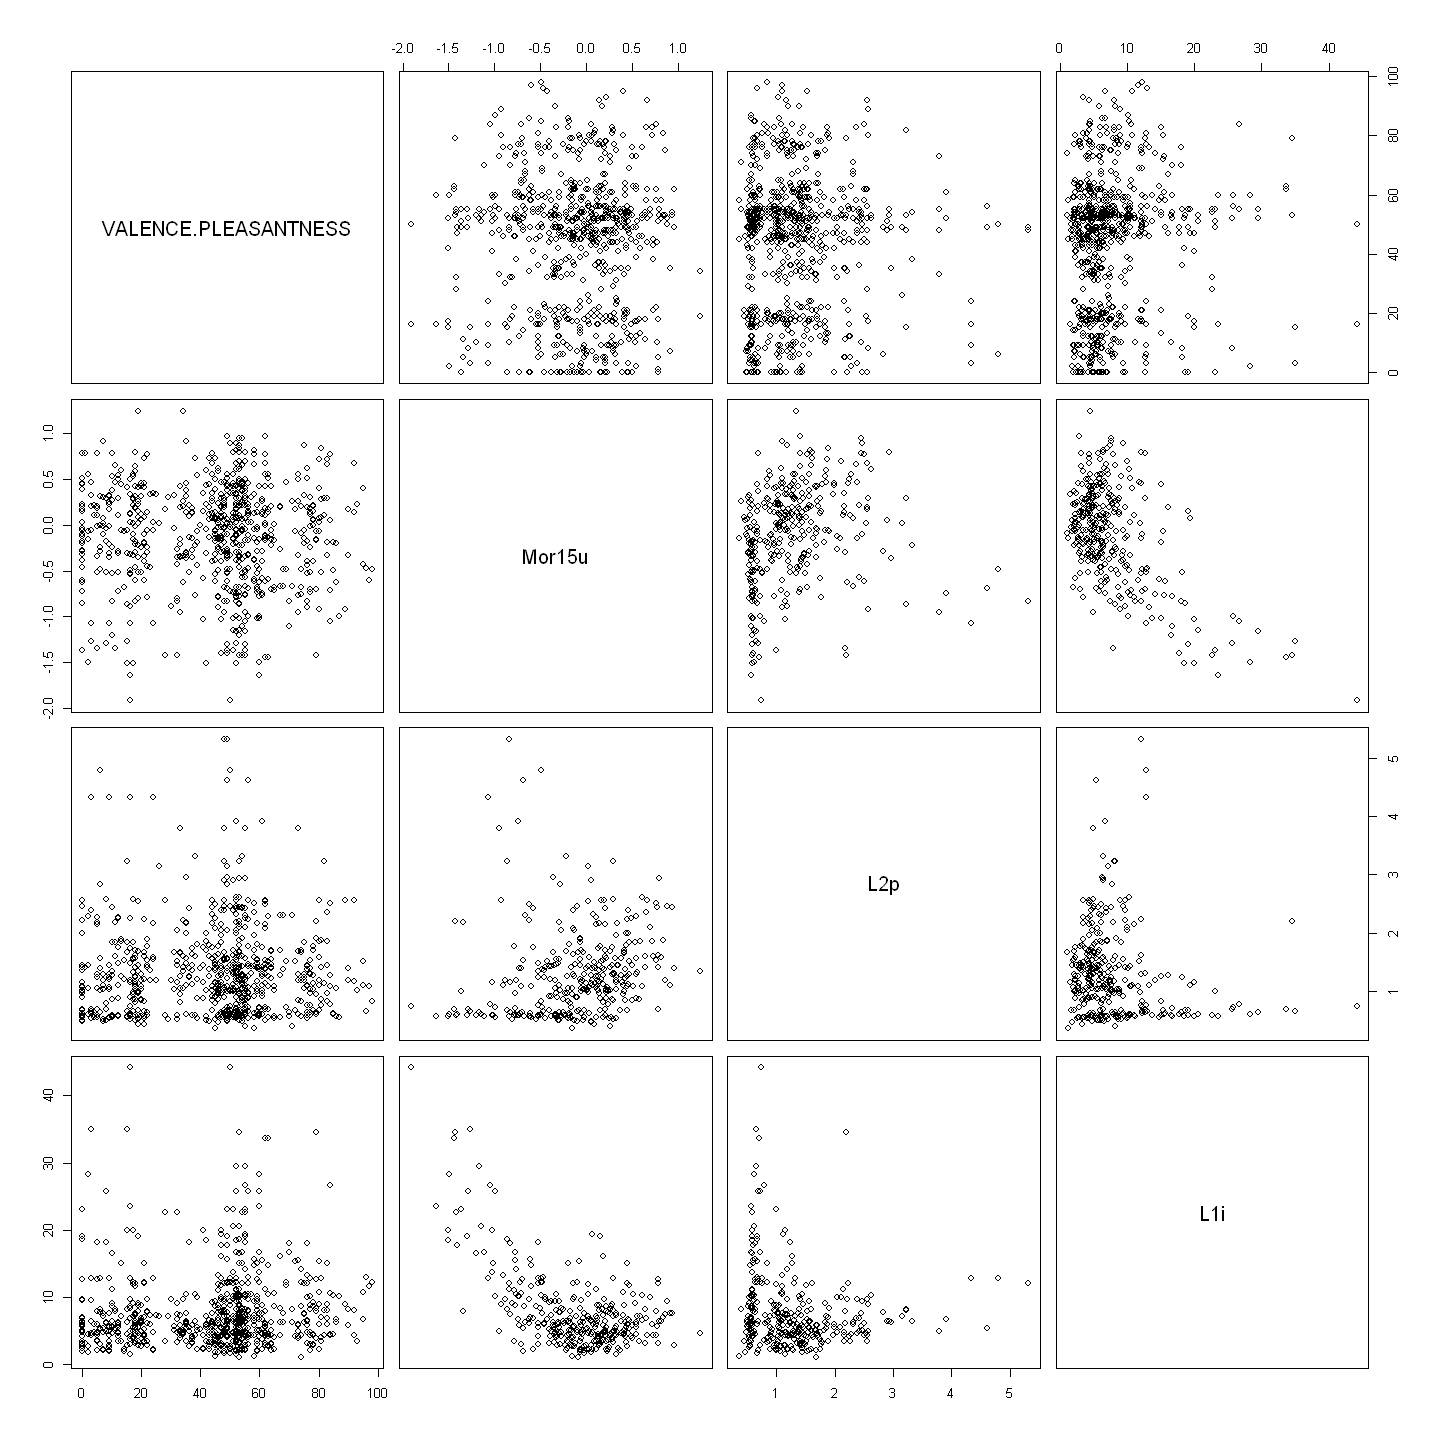

In [105]:
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,2))
set.seed(56)
pairs(data.no.zeros[c(1,sample(1:ncol(data),3))],cex.labels=1.5)

Cheking for pairwise correlation:

In [18]:
library(corrplot)

corrplot 0.84 loaded



In [174]:
cor.mat<-cor(data.no.zeros)

Warning message in cor(data.no.zeros):
"l'écart type est nulle"


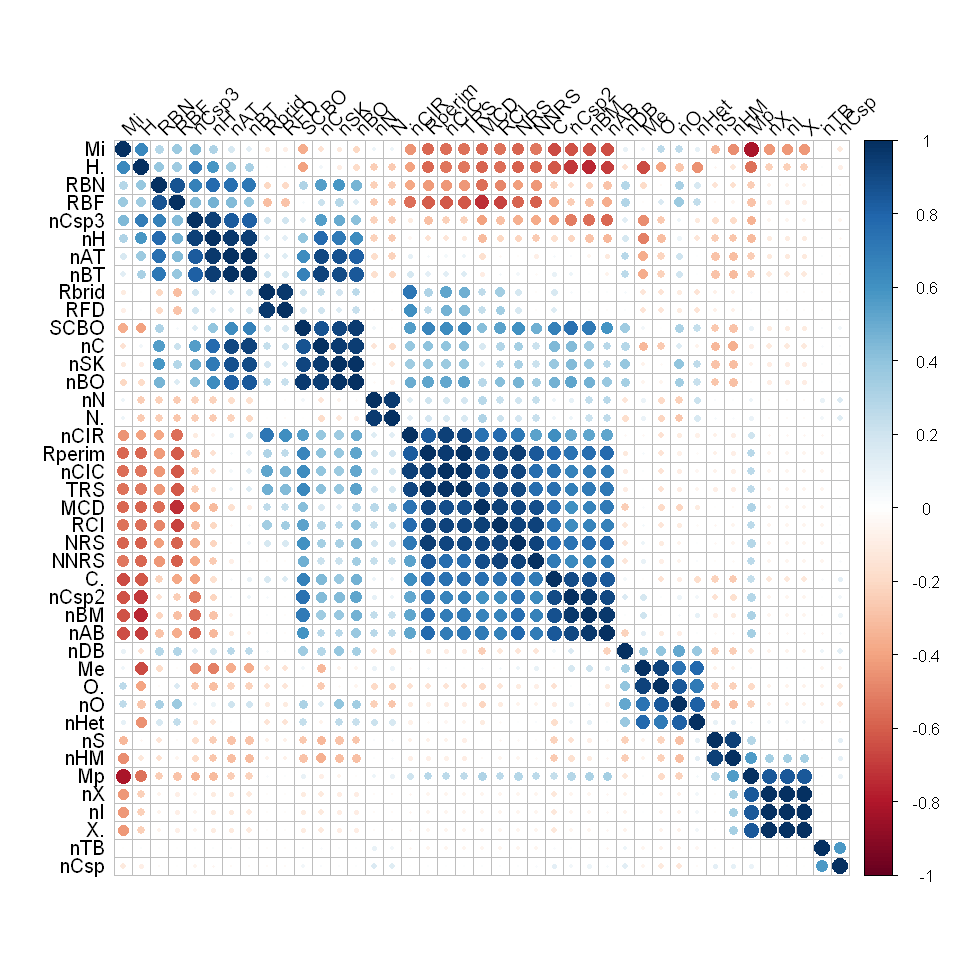

In [175]:
corrplot(cor.mat[10:50,10:50], order="hclust", tl.col="black", tl.srt=45)

We can see on this plot of selected predictors that there is some highly correlated predictors. We will remove one if each the predictors pair having pairwise correlation > 0.99. Later will compare the models based on the data with/without these predictors.

In [107]:
options(repr.plot.width=8, repr.plot.height=8)

In [176]:
flattenCorrMatrix <- function(cormat) {        #function found online and modified, used to get a more comfortable correlation matrix
  ut <- upper.tri(cormat)
  data.frame(row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut])
}

In [288]:
cor.df<-flattenCorrMatrix(cor.mat)
max.cor.rows<-which(abs(cor.df$cor) > 0.99)
max.cor.pred<-cor.df[max.cor.rows,][-3]
dim(max.cor.pred[!duplicated(max.cor.pred$row),])[1]

[1] 1176

There is 1176 predictors with correlation > 0.999, we remove them.

In [294]:
data<-data.no.zeros
data<-data.no.zeros[,!colnames(data)%in%c(max.cor.pred$row)]
dim(data)

[1]  708 1856

We have reduced the number of predictors from 4872 to 1856, not bad ! (not sure now if this is not bad, check the comparison between models later)

# 2. linear regression

Let's firstly split the data in a training and test set (test set on kaggle is for later)

In [295]:
idx.train<-sample(nrow(data), nrow(data)*(2/3)) #2/3 taken into the training set because it will later be splitted again to get a validation set
data.train<-data[idx.train,]
data.test<-data[-idx.train,]
dim(data.train)
dim(data.test)

[1]  472 1856

[1]  236 1856

**Simple linear regression with all the predictors**

Now let's run a simple linear regression on the whole training set. The result will be bad, since p>n it will largely overfit the data, but this result will serve us as baseline for the rest. 

In [296]:
basic.lin.fit<-lm(VALENCE.PLEASANTNESS ~ ., data.train)

In [297]:
train.pred<-predict(basic.lin.fit,data.train)
test.pred<-predict(basic.lin.fit, data.test)
train.RMSE<-sqrt(mean((data.train$VALENCE.PLEASANTNESS-train.pred)^2))
test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-test.pred)^2))
cat("train RMSE: ", train.RMSE,"\n", "test RMSE: ", test.RMSE)

Warning message in predict.lm(basic.lin.fit, data.train):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(basic.lin.fit, data.test):
"prediction from a rank-deficient fit may be misleading"


train RMSE:  12.28949 
 test RMSE:  92541341

We can se the huge test RMSE, coming from the largely overfitting model. 

**Cross-validation choice of best predictors and best number of predictors**

We are in the situation n<p, we have to find the best number of relevant predictors using 5-fold cross-validation on forward subsetting (best subset selection will ask to much computing):

In [299]:
library(leaps)
library(tidymodels)

In [300]:
reg.fit.fwd<-regsubsets(VALENCE.PLEASANTNESS ~ ., data.train, method = 'forward', nvmax=150)
summary.reg<-summary(reg.fit.fwd)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1556  linear dependencies found"


Reordering variables and trying again:


In [301]:
predict.regsubsets<-function(object,newdata,nb,formula=as.formula(object$call[2])){
    mat=model.matrix(formula,newdata)
    coefs=coef(object, id=nb)
    xvars=names(coefs)
    return(mat[,xvars]%*%coefs)
}
fit_and_eval<-function(fold,formula=VALENCE.PLEASANTNESS ~ .){
    fit<-regsubsets(formula, analysis(fold), method='forward', nvmax=50,really.big=T)
    valid.set<-assessment(fold)
    sapply(1:(fit$nvmax-1),
           function(nb) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, nb, formula))^2))
}


The following cell is pretty slow:

In [311]:
set.seed(2)
valid.data<-vfold_cv(data.train,v=5)
cv.errors<-sapply(valid.data$splits,fit_and_eval)
mean.cv.errors<-rowMeans(cv.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1596  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1585  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1599  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1588  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1585  linear dependencies found"


Reordering variables and trying again:


[1] 5
[1] 510.3392
[1] 23.48348


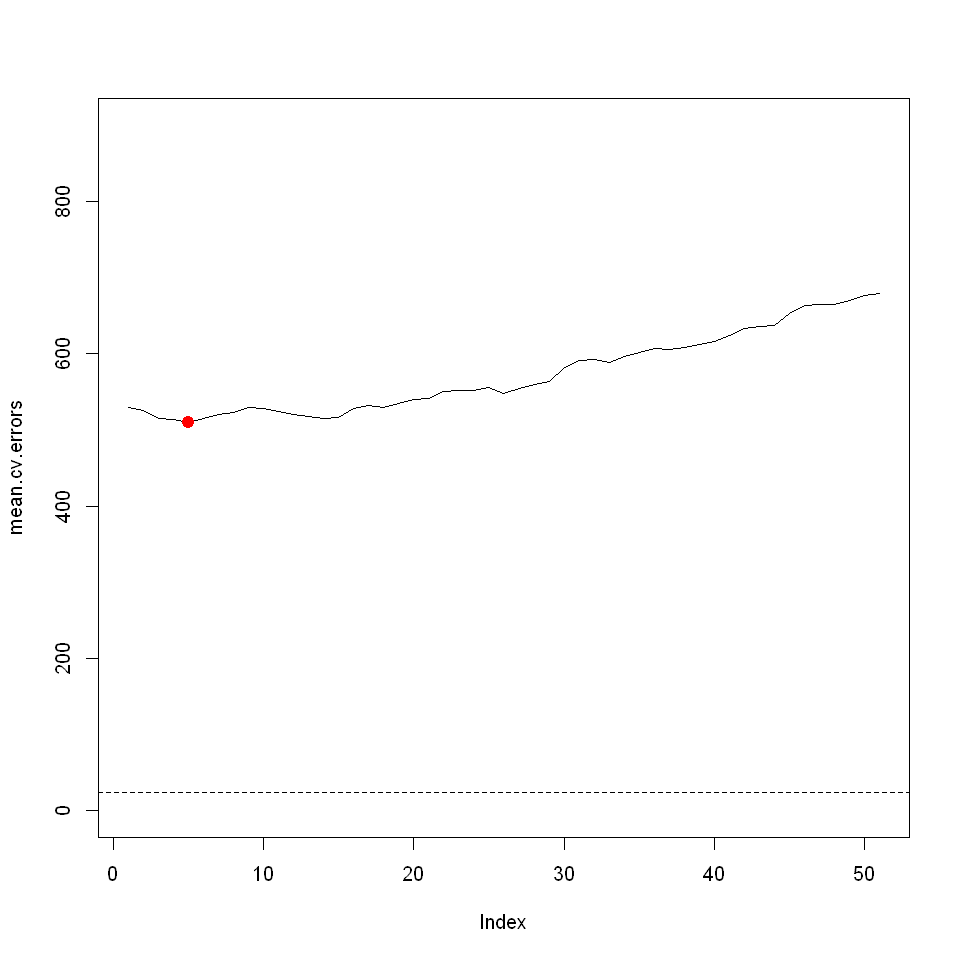

In [312]:
plot(mean.cv.errors, type='l', ylim=c(0,900))
cv.min = which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(data.train$VALENCE.PLEASANTNESS), 0, lty = "dashed")
print(cv.min)
print(mean.cv.errors[cv.min])
print(sd(data.train$VALENCE.PLEASANTNESS))

In [313]:
reg.test.pred<-predict.regsubsets(reg.fit.fwd,data.test, cv.min, formula=VALENCE.PLEASANTNESS ~ .)
reg.test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-reg.test.pred)^2))
print(reg.test.RMSE)

[1] 23.25619


We get an RMSE of ~23.2 on the test set. 

**Lasso regularization**

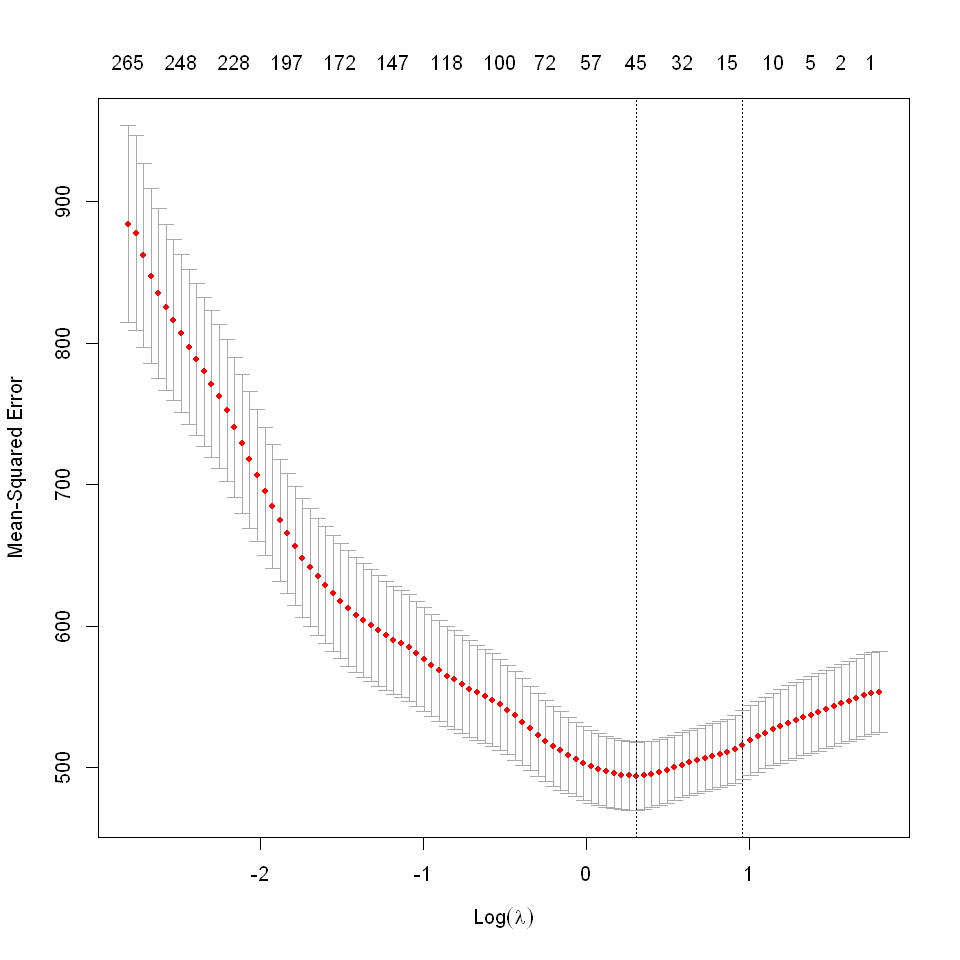

In [314]:
library(glmnet)
set.seed(1)
cv.lasso <- cv.glmnet(as.matrix(data.train[,-1]), data.train$VALENCE.PLEASANTNESS, alpha = 1)
plot(cv.lasso)

In [315]:
best.lasso <- glmnet(as.matrix(data.train[,-1]),data.train$VALENCE.PLEASANTNESS, alpha = 1, lambda = cv.lasso$lambda.min)
lasso.test.pred<-predict(best.lasso, as.matrix(data.test[,-1]),s=cv.lasso$lambda.min)
lasso.test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-lasso.test.pred)^2))
cat('test RMSE of lasso regularized model: ',lasso.test.RMSE)

test RMSE of lasso regularized model:  22.05727

In [317]:
set.seed(1)
cv.lasso.with.corr <- cv.glmnet(as.matrix(data.no.zeros[idx.train,-1]), data.no.zeros$VALENCE.PLEASANTNESS[idx.train], alpha = 1)
best.lasso.with.corr <- glmnet(as.matrix(data.no.zeros[idx.train,-1]),data.no.zeros$VALENCE.PLEASANTNESS[idx.train], alpha = 1, lambda = cv.lasso.with.corr$lambda.min)
lasso.with.corr.test.pred<-predict(best.lasso.with.corr, as.matrix(data.no.zeros[-idx.train,-1]),s=cv.lasso.with.corr$lambda.min)
lasso.with.corr.test.RMSE<-sqrt(mean((data.no.zeros$VALENCE.PLEASANTNESS[-idx.train]-lasso.with.corr.test.pred)^2))
cat('test RMSE of lasso regularized model with correlated predictors', lasso.with.corr.test.RMSE)

test RMSE of lasso regularized model with correlated predictors 22.03898

We see that dropping thousands of highly correlated predictors almost does not impact the final test error. We will continue to use the data without correlated predictors for computing efficiency.

### First sub using lasso

In [ ]:
data.final.test.full<-read.csv(file.path("../data/test_data.csv"))

In [228]:
data.final.test.full$Intensity_high<-ifelse(data.final.test.full$Intensity=='high',1,0)
data.final.test.full$Intensity_low<-ifelse(data.final.test.full$Intensity=='low',1,0)
#data.final.test.full$SWEETORSOUR <-as.integer(data.final.test.full$SWEETORSOUR)
data.final.test.full<-data.final.test.full[,-which(colnames(data.final.test.full)=='Intensity')]
data.final.test<-data.final.test.full[,colnames(data.final.test.full)%in%colnames(data)]

In [229]:
lasso.test.pred<-predict(best.lasso, as.matrix(data.final.test),s=cv.lasso$lambda.min)
lasso.pred.sub<-cbind(which(lasso.test.pred==lasso.test.pred),lasso.test.pred)
colnames(lasso.pred.sub)<-c("id","VALENCE.PLEASANTNESS")

In [230]:
write.csv(lasso.pred.sub,"submisson_lasso.csv", row.names=F)